LLM vs. Lawyers: Identifying a Subset of Summary Judgments in a Large UK Case Law Dataset

In [ ]:
!pip install transformers
!pip install textsum  
!pip install torch torchvision
!pip install selenium
!pip install -U kaleido
!pip install nbconvert

In [1]:
import pandas as pd
from pathlib import Path
import xml.etree.ElementTree as ET
import re
import chardet
from tqdm import tqdm
import plotly.offline as py
import plotly.graph_objs as go
from IPython.display import display
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib_venn import venn3
import os
import time
import logging
from anthropic import Anthropic
import plotly.offline as pyo
from plotly.offline import init_notebook_mode, iplot
import seaborn as sns
from sklearn.cluster import KMeans
import plotly.express as px

pd.options.display.max_columns = None

Load the full Cambridge Law Corpus, and search for cases using the phrase 'Summary Judgment' and its permutations. Count the number of times the phrase(s) occur in each case. Count how many words are used in each case. Extract case ID.

In [ ]:
path = Path(r'C:\Users\...\CambridgeLawCorpus\corpus\cases') 
data = []
error_cases = []  
search_terms = [r'\bsumm[a-z]*\s*judg[a-z]*\b'] 
namespaces = {'ns': 'https://github.com/cambridge-ai-and-law-project/CambridgeLawCorpus'} 

def process_file(file):
    content = None  
    try:
        if file.stat().st_size == 0:
            print(f"Skipped empty file: {file}")
            return None, None

        rawdata = open(file, 'rb').read() 
        result = chardet.detect(rawdata)
        char_enc = result['encoding']

        with open(file, 'r', encoding=char_enc) as f:
            content = f.read()
            content = re.sub(r'\s+', ' ', content)  
            root = ET.fromstring(content)
            court = root.findtext('.//ns:court', namespaces=namespaces) or ''   
            last_date_hearing_delivery = root.findtext('.//ns:last_date_hearing_delivery', namespaces=namespaces) or ''
            case_header = root.findtext('.//ns:case_header', namespaces=namespaces) or ''
            case_body = root.findtext('.//ns:case_body', namespaces=namespaces) or ''
            clc_id = root.findtext('.//ns:CLC-ID', namespaces=namespaces) or ''
            document_source = root.findtext('.//ns:document_source', namespaces=namespaces) or ''

            case_neutral_citations = ', '.join([el.text for el in root.findall('.//ns:case_neutral_citation', namespaces=namespaces)]) #in case there is more than one citation number

            row_dict = {'content': content, 'court': court, 'last_date_hearing_delivery': last_date_hearing_delivery, 
                        'case_header': case_header, 'case_body': case_body, 'case_neutral_citation': case_neutral_citations,
                        'clc_id': clc_id, 'document_source': document_source}

            actual_terms_found = []   

           
            for term in search_terms:    
                matches = re.findall(term, content, re.IGNORECASE)
                if matches:
                   
                    actual_terms_found.extend(matches) 
                    row_dict[term] = 1
                    row_dict[term+'_counts'] = len(matches)
                else:
                    row_dict[term] = 0
                    row_dict[term+'_counts'] = 0
 
            row_dict['actual_terms_found'] = ', '.join(actual_terms_found)   

            return row_dict, None

    except Exception as e:
        print(f"Failed to process file: {file}, due to error: {e}")
        return None, None

files_to_process = list(path.rglob('*.xml')) 
for file in tqdm(files_to_process, desc='Processing files'):
    row_dict, error_case = process_file(file)

    if row_dict is not None:
        data.append(row_dict)

    if error_case is not None:
        error_cases.append(error_case)

df = pd.DataFrame(data)
df['word_count'] = df['case_body'].apply(lambda x: len(str(x).split()))  
df['xml_wordcount'] = df['content'].apply(lambda x: len(str(x).split()))  
df['caseheader_wordcount'] = df['case_header'].apply(lambda x: len(str(x).split()))  
avg_xml_wordcount = df['xml_wordcount'].mean()  
print(f"Average word count in XML content: {avg_xml_wordcount}")

xml_wordcount_distribution = df['xml_wordcount'].value_counts().sort_index() 
print("Distribution of word count in XML content:")
print(xml_wordcount_distribution)

avg_wordcount = df['word_count'].mean()   
print(f"Average word count in case text: {avg_wordcount}")

wordcount_distribution = df['word_count'].value_counts().sort_index() 
print("Distribution of word count in case text:")
print(wordcount_distribution)


df.to_pickle('25Sep_SJ_only_CLC_both_spellings_xml.pkl') 
df_errors = pd.DataFrame(error_cases, columns=['file_path', 'content', 'error']) 
df_errors.to_pickle('25Sep_error_cases_SJ_only_CLC_both_spellings_xml.pkl') 
print("Processing completed. Dataframe saved to 25Sep_SJ_only_CLC_both_spellings.pkl and error cases saved to 25_Sep_error_cases_SJ_only_CLC_both_spellings.pkl.")
SJ_only_CLC_both_spellings = df[df[search_terms[0]+'_counts'] > 0] 

In [59]:
clc=pd.read_pickle('25Sep_SJ_only_CLC_both_spellings_xml.pkl')
clc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312058 entries, 0 to 312057
Data columns (total 14 columns):
 #   Column                              Non-Null Count   Dtype 
---  ------                              --------------   ----- 
 0   content                             312058 non-null  object
 1   court                               312058 non-null  object
 2   last_date_hearing_delivery          312058 non-null  object
 3   case_header                         312058 non-null  object
 4   case_body                           312058 non-null  object
 5   case_neutral_citation               312058 non-null  object
 6   clc_id                              312058 non-null  object
 7   document_source                     312058 non-null  object
 8   \bsumm[a-z]*\s*judg[a-z]*\b         312058 non-null  int64 
 9   \bsumm[a-z]*\s*judg[a-z]*\b_counts  312058 non-null  int64 
 10  actual_terms_found                  312058 non-null  object
 11  word_count                          312

Find the average word count per court

In [ ]:
clc['word_count'] = clc['content'].apply(lambda x: len(x.split()))

average_word_count_per_court = clc.groupby('court')['word_count'].mean().reset_index()

Find the overall average word count for all courts

In [61]:
overall_average_word_count = average_word_count_per_court['word_count'].mean()
print("Overall average word count across all courts:", overall_average_word_count)

Overall average word count across all courts: 5824.229966749891


Count the number many court cases have the SJ expression in them:

In [ ]:
column_name = SJ_only_CLC_both_spellings.columns[SJ_only_CLC_both_spellings.columns.to_list().index('\\bsumm[a-z]*\\s*judg[a-z]*\\b')]
count_ones = (SJ_only_CLC_both_spellings[column_name] == 1).sum()

Save the cases that have the phrase(s) in them into an new dataset. This is refered to in the paper as the RegEx SJ dataset

In [ ]:
column_name = df.columns[df.columns.to_list().index('\\bsumm[a-z]*\\s*judg[a-z]*\\b')]
SJ_term_cases_25_Sep = df[df[column_name] == 1]
SJ_term_cases_25_Sep.to_pickle('SJ_term_cases_25_Sep.pkl')

Place cases where the phrase 'summary judgement' and its permutations do not occur in a new dataframe

In [ ]:
def extract_non_matching_cases(pickle_path, search_term_pattern):

    df = pd.read_pickle(pickle_path)

    non_matching_cases = df[df[search_term_pattern+'_counts'] == 0]
    
    return non_matching_cases

pickle_file_path = '25Sep_SJ_only_CLC_both_spellings_xml.pkl'
search_term = r'\bsumm[a-z]*\s*judg[a-z]*\b'
non_matches_df = extract_non_matching_cases(pickle_file_path, search_term)
non_matches_df.to_pickle('25Sep_non_matching_cases.pkl')

Re-load the dataframe that contain phrase 'summary judgement' and its permutations (if re-starting notebook)

In [149]:
SJ_term_cases_25_Sep = pd.read_pickle('SJ_term_cases_25_Sep.pkl')

In [150]:
df = SJ_term_cases_25_Sep
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5953 entries, 2 to 311804
Data columns (total 14 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   content                             5953 non-null   object
 1   court                               5953 non-null   object
 2   last_date_hearing_delivery          5953 non-null   object
 3   case_header                         5953 non-null   object
 4   case_body                           5953 non-null   object
 5   case_neutral_citation               5953 non-null   object
 6   clc_id                              5953 non-null   object
 7   document_source                     5953 non-null   object
 8   \bsumm[a-z]*\s*judg[a-z]*\b         5953 non-null   int64 
 9   \bsumm[a-z]*\s*judg[a-z]*\b_counts  5953 non-null   int64 
 10  actual_terms_found                  5953 non-null   object
 11  word_count                          5953 non-null   in

In [151]:
df.head()

,content,court,last_date_hearing_delivery,case_header,case_body,case_neutral_citation,clc_id,document_source,\bsumm[a-z]*\s*judg[a-z]*\b,\bsumm[a-z]*\s*judg[a-z]*\b_counts,actual_terms_found,word_count,xml_wordcount,caseheader_wordcount
2,"<?xml version=""1.0"" encoding=""UTF-8""?> <basic_...",United Kingdom Competition Appeals Tribunal,2001-08-08,,,[2001] CAT 3,df553efe-02a5-46db-9f79-de5ef76b6c4e,html,1,1,summary judgment,0,14410,0
35,"<?xml version=""1.0"" encoding=""UTF-8""?> <basic_...",United Kingdom Competition Appeals Tribunal,2005-07-06,,,[2005] CAT 25,db855910-8218-4e28-a550-3216d16f7fea,html,1,1,summary judgment,0,37591,0
75,"<?xml version=""1.0"" encoding=""UTF-8""?> <basic_...",United Kingdom Competition Appeals Tribunal,2006-11-15,,,[2006] CAT 28,ecdc85d9-f1aa-4f8f-a966-73ca7c3a94d2,html,1,1,summary judgment,0,12331,0
93,"<?xml version=""1.0"" encoding=""UTF-8""?> <basic_...",United Kingdom Competition Appeals Tribunal,2007-02-28,,,[2007] CAT 12,f69c7ebb-f7d9-441e-ada9-2533e7d81aac,html,1,1,summary judgment,0,12584,0
198,"<?xml version=""1.0"" encoding=""UTF-8""?> <basic_...",United Kingdom Competition Appeals Tribunal,2009-03-12,,,[2009] CAT 7,815e0590-533c-49c5-9678-8869cdbbc9b7,html,1,2,"summary judgment, summary judgment",0,7848,0


In [152]:
#note: when we do the search with the exact phrase for summary judgement we get 5916 cases 

Search the RegEx SJ dataset for the keyword search terms given in Table 1 in the paper and listed below. Find the number of cases where each keyword occurs exclusively to all other Keywords.

In [153]:
df['content'] = df['content'].str.lower() 
key_phrases = [
    'summary judgment', 'summary judgement',
    'compelling reason why the case or issue should be disposed of at a trial',
    'compelling reason to try the case or issue',
    'civil procedure rules part 24', 'cpr 24', 'cpr 24.2', 'cpr part 24',
    'part 24 of the civil procedure rules', 'part 24 application',
    'part 24 judgement', 'part 24 judgment', 'r 24.2', 'r. 24.2', 'rule 24.2',
    'easyair v opal', 'easyair ltd v opal telecom',
    'easyair ltd. (t.a openair) v. opal telecom ltd [2009] ewhc 339 (ch)',
    'ewhc 339 (ch)', 'real prospect of success', 'real prospect of succeeding',
    'realistic prospect of success', 'realistic prospect of succeeding',
    'no real prospect', 'no real prospect of succeeding', 'no real prospect of success',
    'fanciful not real', 'realistic as opposed to a fanciful',
    'real as opposed to a fanciful', 'real and not merely fanciful',
    'more than fanciful', 'mini trial', 'mini-trial',
    'must not conduct a mini-trial'
]

 
exclusive_counts = {phrase: 0 for phrase in key_phrases}

 
def is_exclusive(row, phrase):
    if phrase in row:
        return all(other_phrase not in row or other_phrase == phrase for other_phrase in key_phrases)
    return False
 
for index, row in df.iterrows():
    content = row['content']
    for phrase in key_phrases:
        if is_exclusive(content, phrase):
            exclusive_counts[phrase] += 1

print(exclusive_counts)

{'summary judgment': 2511, 'summary judgement': 54, 'compelling reason why the case or issue should be disposed of at a trial': 0, 'compelling reason to try the case or issue': 0, 'civil procedure rules part 24': 0, 'cpr 24': 0, 'cpr 24.2': 0, 'cpr part 24': 0, 'part 24 of the civil procedure rules': 0, 'part 24 application': 0, 'part 24 judgement': 0, 'part 24 judgment': 0, 'r 24.2': 0, 'r. 24.2': 0, 'rule 24.2': 0, 'easyair v opal': 0, 'easyair ltd v opal telecom': 0, 'easyair ltd. (t.a openair) v. opal telecom ltd [2009] ewhc 339 (ch)': 0, 'ewhc 339 (ch)': 0, 'real prospect of success': 0, 'real prospect of succeeding': 0, 'realistic prospect of success': 0, 'realistic prospect of succeeding': 0, 'no real prospect': 0, 'no real prospect of succeeding': 0, 'no real prospect of success': 0, 'fanciful not real': 0, 'realistic as opposed to a fanciful': 0, 'real as opposed to a fanciful': 0, 'real and not merely fanciful': 0, 'more than fanciful': 0, 'mini trial': 0, 'mini-trial': 0, 'm

Find the exclusive keyword phrases (i.e., those that occur without any other keywords phrases)

In [154]:
def mark_exclusive(row):
    found_phrases = [phrase for phrase in key_phrases if phrase in row]
    return found_phrases[0] if len(found_phrases) == 1 else None

df['exclusive_phrase'] = df['content'].apply(mark_exclusive)

exclusive_counts = df['exclusive_phrase'].value_counts()

exclusive_counts_dict = exclusive_counts.to_dict()

print(exclusive_counts_dict)

{'summary judgment': 2511, 'summary judgement': 54}


Count the occurrences of each keyword phrase in each document, and plot as a bar chart

In [155]:
key_phrases = [
    'summary judgment', 'summary judgement',
    'compelling reason why the case or issue should be disposed of at a trial',
    'compelling reason to try the case or issue',
    'civil procedure rules part 24', 'cpr 24', 'cpr 24.2', 'cpr part 24',
    'part 24 of the civil procedure rules', 'part 24 application',
    'part 24 judgement', 'part 24 judgment', 'r 24.2', 'r. 24.2', 'rule 24.2',
    'easyair v opal', 'easyair ltd v opal telecom',
    'easyair ltd. (t.a openair) v. opal telecom ltd [2009] ewhc 339 (ch)',
    'ewhc 339 (ch)', 'real prospect of success', 'real prospect of succeeding',
    'realistic prospect of success', 'realistic prospect of succeeding',
    'no real prospect', 'no real prospect of succeeding', 'no real prospect of success',
    'fanciful not real', 'realistic as opposed to a fanciful',
    'real as opposed to a fanciful', 'real and not merely fanciful',
    'more than fanciful', 'mini trial', 'mini-trial',
    'must not conduct a mini-trial'
]


def count_phrase_occurrences(text, phrase):
    return text.count(phrase)

phrase_counts = {phrase: 0 for phrase in key_phrases}

for phrase in key_phrases:
    phrase_counts[phrase] = df['content'].apply(lambda x: count_phrase_occurrences(x, phrase)).sum()

data = [go.Bar(
    x=list(phrase_counts.keys()),
    y=list(phrase_counts.values())
)]


layout = go.Layout(
    title='Occurrences of Key Phrases in Documents',
    yaxis=dict(title='Count')
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

In [156]:
for phrase, count in phrase_counts.items():
    print(f"'{phrase}': {count}")

'summary judgment': 27061
'summary judgement': 531
'compelling reason why the case or issue should be disposed of at a trial': 278
'compelling reason to try the case or issue': 0
'civil procedure rules part 24': 7
'cpr 24': 1616
'cpr 24.2': 1009
'cpr part 24': 1244
'part 24 of the civil procedure rules': 90
'part 24 application': 456
'part 24 judgement': 0
'part 24 judgment': 31
'r 24.2': 1115
'r. 24.2': 56
'rule 24.2': 389
'easyair v opal': 38
'easyair ltd v opal telecom': 238
'easyair ltd. (t.a openair) v. opal telecom ltd [2009] ewhc 339 (ch)': 3
'ewhc 339 (ch)': 431
'real prospect of success': 5576
'real prospect of succeeding': 1533
'realistic prospect of success': 914
'realistic prospect of succeeding': 74
'no real prospect': 6012
'no real prospect of succeeding': 1330
'no real prospect of success': 2843
'fanciful not real': 1
'realistic as opposed to a fanciful': 38
'real as opposed to a fanciful': 56
'real and not merely fanciful': 2
'more than fanciful': 156
'mini trial': 256


Print the counts for each keyword phrase for Table 2

In [157]:
sorted_phrase_counts = dict(sorted(phrase_counts.items(), key=lambda item: item[1], reverse=True))
for phrase, count in sorted_phrase_counts.items():
    print(f"'{phrase}': {count}")
df_sorted = pd.DataFrame(list(sorted_phrase_counts.items()), columns=['Key Phrase', 'Count'])

'summary judgment': 27061
'no real prospect': 6012
'real prospect of success': 5576
'no real prospect of success': 2843
'cpr 24': 1616
'real prospect of succeeding': 1533
'no real prospect of succeeding': 1330
'cpr part 24': 1244
'mini-trial': 1213
'r 24.2': 1115
'cpr 24.2': 1009
'realistic prospect of success': 914
'summary judgement': 531
'part 24 application': 456
'ewhc 339 (ch)': 431
'rule 24.2': 389
'compelling reason why the case or issue should be disposed of at a trial': 278
'mini trial': 256
'easyair ltd v opal telecom': 238
'more than fanciful': 156
'part 24 of the civil procedure rules': 90
'realistic prospect of succeeding': 74
'r. 24.2': 56
'real as opposed to a fanciful': 56
'easyair v opal': 38
'realistic as opposed to a fanciful': 38
'must not conduct a mini-trial': 36
'part 24 judgment': 31
'civil procedure rules part 24': 7
'easyair ltd. (t.a openair) v. opal telecom ltd [2009] ewhc 339 (ch)': 3
'real and not merely fanciful': 2
'fanciful not real': 1
'compelling reas

Find the co-occurrence matrix (count if each keyword is present in a case, then count the number of pairs (co-occurrence) made for all cases)

In [158]:
co_counts = pd.DataFrame(index=df.index)
def is_phrase_present(text, phrase):
    return 1 if phrase in text else 0 #DataFrame with '1' and '0' indicating the presence of keywords

for phrase in key_phrases:
    co_counts[phrase] = df['content'].apply(lambda x: is_phrase_present(x, phrase))

In [159]:
co_counts.head()

,summary judgment,summary judgement,compelling reason why the case or issue should be disposed of at a trial,compelling reason to try the case or issue,civil procedure rules part 24,cpr 24,cpr 24.2,cpr part 24,part 24 of the civil procedure rules,part 24 application,part 24 judgement,part 24 judgment,r 24.2,r. 24.2,rule 24.2,easyair v opal,easyair ltd v opal telecom,easyair ltd. (t.a openair) v. opal telecom ltd [2009] ewhc 339 (ch),ewhc 339 (ch),real prospect of success,real prospect of succeeding,realistic prospect of success,realistic prospect of succeeding,no real prospect,no real prospect of succeeding,no real prospect of success,fanciful not real,realistic as opposed to a fanciful,real as opposed to a fanciful,real and not merely fanciful,more than fanciful,mini trial,mini-trial,must not conduct a mini-trial
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
35,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
75,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
93,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
198,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0



Calculate co-occurrences for each pair of keywords

In [160]:
co_occurrence_counts = pd.DataFrame(0, index=key_phrases, columns=key_phrases)

for phrase1 in key_phrases:
    for phrase2 in key_phrases:
        co_occurrence_counts.at[phrase1, phrase2] = (co_counts[phrase1] & co_counts[phrase2]).sum()

In [161]:
co_occurrence_counts.head()

,summary judgment,summary judgement,compelling reason why the case or issue should be disposed of at a trial,compelling reason to try the case or issue,civil procedure rules part 24,cpr 24,cpr 24.2,cpr part 24,part 24 of the civil procedure rules,part 24 application,part 24 judgement,part 24 judgment,r 24.2,r. 24.2,rule 24.2,easyair v opal,easyair ltd v opal telecom,easyair ltd. (t.a openair) v. opal telecom ltd [2009] ewhc 339 (ch),ewhc 339 (ch),real prospect of success,real prospect of succeeding,realistic prospect of success,realistic prospect of succeeding,no real prospect,no real prospect of succeeding,no real prospect of success,fanciful not real,realistic as opposed to a fanciful,real as opposed to a fanciful,real and not merely fanciful,more than fanciful,mini trial,mini-trial,must not conduct a mini-trial
summary judgment,5819,147,269,0,7,889,616,815,81,214,0,27,670,37,249,38,233,3,412,2013,982,508,58,2212,893,1465,1,38,52,2,130,204,809,35
summary judgement,147,251,26,0,0,51,38,38,0,11,0,0,39,0,10,2,11,0,20,84,55,25,5,98,53,69,0,3,3,0,6,21,64,1
compelling reason why the case or issue should be disposed of at a trial,269,26,269,0,2,164,140,95,8,21,0,1,149,14,68,3,60,3,101,233,222,62,5,263,221,215,0,6,10,0,17,35,154,8
compelling reason to try the case or issue,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
civil procedure rules part 24,7,0,2,0,7,1,0,1,1,1,0,0,0,1,1,0,0,2,2,5,3,1,0,5,3,4,0,0,0,0,1,3,0,0


In [162]:
co_occurrence_counts.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34 entries, summary judgment to must not conduct a mini-trial
Data columns (total 34 columns):
 #   Column                                                                    Non-Null Count  Dtype
---  ------                                                                    --------------  -----
 0   summary judgment                                                          34 non-null     int64
 1   summary judgement                                                         34 non-null     int64
 2   compelling reason why the case or issue should be disposed of at a trial  34 non-null     int64
 3   compelling reason to try the case or issue                                34 non-null     int64
 4   civil procedure rules part 24                                             34 non-null     int64
 5   cpr 24                                                                    34 non-null     int64
 6   cpr 24.2                                       

In [163]:
co_occurrence_counts.to_csv('fullmatrix.csv')

Plot the co-occurrence matrix (figure 1)

In [164]:
trace = go.Heatmap(
    z=co_occurrence_counts.values,
    x=co_occurrence_counts.columns,
    y=co_occurrence_counts.index,
    colorscale='YlGnBu'
)


annotations = []
for yd, row in enumerate(co_occurrence_counts.values):
    for xd, value in enumerate(row):
        annotations.append(
            dict(
                x=co_occurrence_counts.columns[xd],
                y=co_occurrence_counts.index[yd],
                text=str(value),
                xref='x1',
                yref='y1',
                font=dict(size=8),
                showarrow=False
            )
        )

        
layout = go.Layout(
    title='Co-OccurrenAce Heatmap of Key Phrases',
    xaxis=dict(tickangle=-45, tickfont=dict(size=12)),
    yaxis=dict(tickfont=dict(size=12)),
    annotations=annotations,
    autosize=False,
    width=1400,
    height=1000
)

fig = go.Figure(data=[trace], layout=layout)
py.init_notebook_mode(connected=True)
py.iplot(fig) 

In [165]:
trace = go.Heatmap(
    z=co_occurrence_counts.values,
    x=co_occurrence_counts.columns,
    y=co_occurrence_counts.index,
    colorscale='YlGnBu'
)

annotations = []
for yd, row in enumerate(co_occurrence_counts.values):
    for xd, value in enumerate(row):
        annotations.append(
            dict(
                x=co_occurrence_counts.columns[xd],
                y=co_occurrence_counts.index[yd],
                text=str(value),
                xref='x1',
                yref='y1',
                font=dict(size=8),
                showarrow=False
            )
        )

layout = go.Layout(
    title='Co-Occurrence Heatmap of Key Phrases',
    xaxis=dict(tickangle=-45, tickfont=dict(size=12)),
    yaxis=dict(tickfont=dict(size=12)),
    annotations=annotations,
    autosize=False,
    width=1400,
    height=1000
)

fig = go.Figure(data=[trace], layout=layout)

py.init_notebook_mode(connected=True)

py.iplot(fig)

Print the top 5 and bottom 5 co-occurrences

In [76]:
def print_top_and_bottom_co_occurrences(co_occurrence_counts):
    flattened = co_occurrence_counts.stack()
    sorted_flattened = flattened.sort_values()
    print("Bottom 5 Co-Occurrences:")
    print(sorted_flattened.head(10))
    print("\nTop 5 Co-Occurrences:")
    print(sorted_flattened.tail(20))
print_top_and_bottom_co_occurrences(co_occurrence_counts)

Bottom 5 Co-Occurrences:
realistic prospect of succeeding  must not conduct a mini-trial                                          0
r. 24.2                           real and not merely fanciful                                           0
cpr 24.2                          fanciful not real                                                      0
rule 24.2                         compelling reason to try the case or issue                             0
more than fanciful                compelling reason to try the case or issue                             0
real as opposed to a fanciful     civil procedure rules part 24                                          0
                                  compelling reason to try the case or issue                             0
rule 24.2                         part 24 judgement                                                      0
real and not merely fanciful      must not conduct a mini-trial                                          0
rule 24.2   

Demonstrating that the co-occurence of a phrase with itself is not double counted:


In [166]:
phrase = 'summary judgement'

def count_occurrences(text, phrase):
    return len(re.findall(re.escape(phrase), text))

df['phrase_count'] = df['content'].apply(lambda x: count_occurrences(x, phrase))

count_at_least_once = len(df[df['phrase_count'] >= 1])
count_more_than_once = len(df[df['phrase_count'] > 1])

print(f"The phrase '{phrase}' occurs at least once in {count_at_least_once} rows.")
print(f"The phrase '{phrase}' occurs more than once in {count_more_than_once} rows.")

count = df['content'].apply(lambda x: 'real prospect of success' in x).sum()

print("The phrase 'real prospect of success' occurs at least once in", count, "rows.")

The phrase 'summary judgement' occurs at least once in 251 rows.
The phrase 'summary judgement' occurs more than once in 70 rows.
The phrase 'real prospect of success' occurs at least once in 2025 rows.


Plot figure 1 again but as an HTML plot for publication:

In [167]:
trace = go.Heatmap(
    z=co_occurrence_counts.values,
    x=co_occurrence_counts.columns,
    y=co_occurrence_counts.index,
    colorscale='YlGnBu'
)

annotations = []
for yd, row in enumerate(co_occurrence_counts.values):
    for xd, value in enumerate(row):
        annotations.append(
            dict(
                x=co_occurrence_counts.columns[xd],
                y=co_occurrence_counts.index[yd],
                text=str(value),
                xref='x1',
                yref='y1',
                font=dict(size=8),
                showarrow=False
            )
        )

layout = go.Layout(
    title='Co-Occurrence Heatmap of Key Phrases',
    xaxis=dict(tickangle=-45, tickfont=dict(size=12)),
    yaxis=dict(tickfont=dict(size=12)),
    annotations=annotations,
    autosize=False,
    width=1400,
    height=1000
)

fig = go.Figure(data=[trace], layout=layout)
py.plot(fig, filename='figure_1.html')

'figure_1.html'

Calculate the tripple co-occurence matrix for the keywords

In [168]:
phrases = [
    "summary judgment",
    "real prospect of success",
    "compelling reason why the case or issue should be disposed of at a trial"
]

Cot = pd.DataFrame()

Cot['triple'] = df['content'].apply(lambda x: all(phrase in x for phrase in phrases)).astype(int)

for i in range(len(phrases)):
    for j in range(i+1, len(phrases)):
        column_name = f'pair_{i+1}_{j+1}'
        Cot[column_name] = df['content'].apply(lambda x: (phrases[i] in x) and (phrases[j] in x)).astype(int)

for i, phrase in enumerate(phrases):
    column_name = f'phrase_{i+1}'
    Cot[column_name] = df['content'].apply(lambda x: phrase in x).astype(int)

print(Cot.head())

     triple  pair_1_2  pair_1_3  pair_2_3  phrase_1  phrase_2  phrase_3
2         0         0         0         0         1         0         0
35        0         0         0         0         1         0         0
75        0         0         0         0         1         0         0
93        0         0         0         0         1         0         0
198       0         0         0         0         1         0         0


Calculate the Venns 

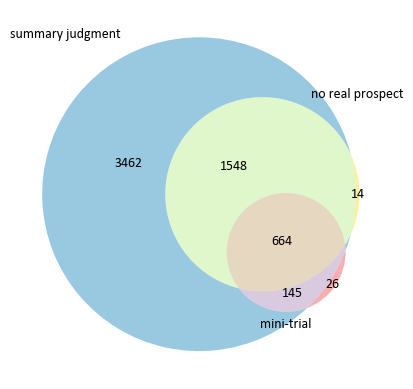

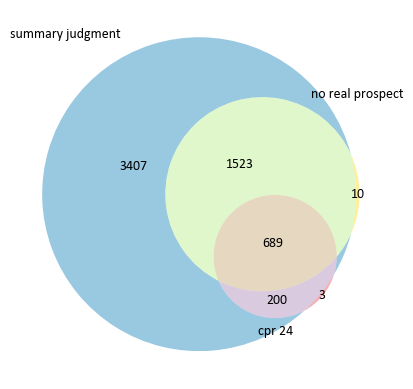

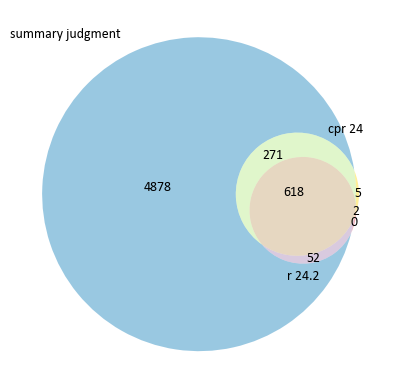

In [170]:


sets = [
    [
        "summary judgment",
        "no real prospect",
        "mini-trial"
    ],
    [
        "summary judgment",
        "no real prospect",
        "cpr 24"
    ],
    

    [
        "summary judgment",
        "cpr 24",
        "r 24.2" 
    ]

]

def create_venn_diagram(phrases, df, set_number):

    Cot = pd.DataFrame()
    Cot['triple'] = df['content'].apply(lambda x: all(phrase in x for phrase in phrases)).astype(int)
    for i in range(len(phrases)):
        for j in range(i + 1, len(phrases)):
            column_name = f'pair_{i + 1}_{j + 1}'
            Cot[column_name] = df['content'].apply(lambda x: (phrases[i] in x) and (phrases[j] in x)).astype(int)
    for i, phrase in enumerate(phrases):
        column_name = f'phrase_{i + 1}'
        Cot[column_name] = df['content'].apply(lambda x: phrase in x).astype(int)
    triple_count = Cot['triple'].sum()
    pair_1_2_count = Cot['pair_1_2'].sum() - triple_count
    pair_1_3_count = Cot['pair_1_3'].sum() - triple_count
    pair_2_3_count = Cot['pair_2_3'].sum() - triple_count
    phrase_1_only = Cot['phrase_1'].sum() - pair_1_2_count - pair_1_3_count - triple_count
    phrase_2_only = Cot['phrase_2'].sum() - pair_1_2_count - pair_2_3_count - triple_count
    phrase_3_only = Cot['phrase_3'].sum() - pair_1_3_count - pair_2_3_count - triple_count
    soft_colors=('#0077B6', '#FFD700', '#E63946')

    venn = venn3(subsets=(phrase_1_only, phrase_2_only, pair_1_2_count, phrase_3_only, pair_1_3_count, pair_2_3_count, triple_count),
                 set_labels=(phrases[0], phrases[1], phrases[2]),
                 set_colors=soft_colors)

    for text in venn.set_labels:
        if text is not None:
            text.set_fontsize(10) 
            text.set_family('Calibri')

    for text in venn.subset_labels:
        if text is not None:
            text.set_fontsize(10)  
            text.set_family('Calibri')
   # plt.show()

    plt.savefig(f'venn_diagram_set_{set_number}.png', dpi=300)
    plt.show()
    plt.close()

for i, set_phrases in enumerate(sets):
    create_venn_diagram(set_phrases, df, i + 1)


RegEx calculation using logical operators  

In [82]:
df = pd.read_pickle('SJ_term_cases_25_Sep.pkl')
df = df.reset_index(drop=True)

batches = {
    'Initial Filter': r'(?i)this is an application for summary judgment',
    'SJ + compelling reason': r'(?i)(summary judgment|summary judgement).* (compelling reason why the case or issue should be disposed of at a trial|compelling reason to try the case or issue)',
    'SJ + CPR 24': r'(?i)(summary judgment|summary judgement).* (civil procedure rules part 24|cpr 24|cpr 24\.2|cpr part 24|part 24 of the civil procedure rules|part 24 application|part 24 judgement|part 24 judgment|r 24\.2|r\. 24\.2|rule 24\.2|summary judgment application)',
    'SJ + easyair v opal': r'(?i)(summary judgment|summary judgement).* (easyair v opal|easyair ltd v opal telecom|easyair ltd\. \(t\.a openair\) v\. opal telecom ltd \[2009\] ewhc 339 \(ch\)|ewhc 339 \(ch\))',
    'SJ + real prospect of success + CPR 24': r'(?i)(summary judgment|summary judgement).* (real prospect of success|real prospect of succeeding|realistic prospect of success|realistic prospect of succeeding|no real prospect|no real prospect of succeeding|no real prospect of success).* (civil procedure rules part 24|cpr 24|cpr 24\.2|cpr part 24|part 24 of the civil procedure rules|part 24 application|part 24 judgement|part 24 judgment|r 24\.2|r\. 24\.2|rule 24\.2|summary judgment application)',
    'SJ + real prospect of success + fanciful not real': r'(?i)(summary judgment|summary judgement).* (real prospect of success|real prospect of succeeding|realistic prospect of success|realistic prospect of succeeding|no real prospect|no real prospect of succeeding|no real prospect of success).* (fanciful not real|realistic as opposed to a fanciful|real as opposed to a fanciful|real and not merely fanciful|more than fanciful)',
    'SJ + real prospect of success + mini trial': r'(?i)(summary judgment|summary judgement).* (real prospect of success|real prospect of succeeding|realistic prospect of success|realistic prospect of succeeding|no real prospect|no real prospect of succeeding|no real prospect of success).* (mini trial|mini-trial|must not conduct a mini-trial)'
}

def find_batch(text):
    for batch_name, pattern in batches.items():
        if re.search(pattern, text):
            return True
    return False

matches = df[df['content'].apply(find_batch)]
matches.to_pickle('17_10_matches_initial.pkl')

exclusions = {
    'E1': r'(?i)application to amend the claim form|application to amend a claim form|application to amend the Defence|an amendment to a claim form under CPR 17\.3|application for permission to amend',
    'E2': r'(?i)application to serve outside the jurisdiction|application for permission to serve outside the jurisdiction|merits of the relevant claim under CPR r\.6\.37\(1\)\(b\)|under CPR rr\. 6\.36, 6\.37 and 6\.38',
    'E3': r'(?i)set aside a default judgment|set aside or vary a judgment|set aside a judgment entered in default.*CPR 13|CPR 13\.3'
}


def find_exclusion(text):
    for exclusion_name, pattern in exclusions.items():
        if re.search(pattern, text):
            return True
    return False

excluded_due_to_exclusion = matches[matches['content'].apply(find_exclusion)]
excluded_due_to_exclusion.to_pickle('excluded_due_to_exclusion.pkl')

matches = matches[~matches['content'].apply(find_exclusion)]
matches.to_pickle('17_10_matches.pkl')


def get_non_matched_rows(original_df):
    non_matches = original_df[~original_df['content'].apply(find_batch)]
    return non_matches

non_matched_df = get_non_matched_rows(df)
non_matched_df.to_pickle('17_10_non_matched_df.pkl')

def combine_non_matching_dataframes(non_matched_df, excluded_due_to_exclusion):
    all_non_matching_cases = pd.concat([non_matched_df, excluded_due_to_exclusion], axis=0)
    return all_non_matching_cases

all_non_matching_cases = combine_non_matching_dataframes(non_matched_df, excluded_due_to_exclusion)
all_non_matching_cases.to_pickle('all_non_matching_cases.pkl')

print("\nTotal cases matching the full search terms (inlcusion and exclusion patterns applies):")
matches.info()

print("\nCases not matched to the search batches")
non_matched_df.info()

print("\nCases excluded due to exclution filter:")
excluded_due_to_exclusion.info()

print("\nTotal Cases removed")
all_non_matching_cases.info()



Total cases matching the full search terms (inlcusion and exclusion patterns applies):
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2408 entries, 2 to 5947
Data columns (total 14 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   content                             2408 non-null   object
 1   court                               2408 non-null   object
 2   last_date_hearing_delivery          2408 non-null   object
 3   case_header                         2408 non-null   object
 4   case_body                           2408 non-null   object
 5   case_neutral_citation               2408 non-null   object
 6   clc_id                              2408 non-null   object
 7   document_source                     2408 non-null   object
 8   \bsumm[a-z]*\s*judg[a-z]*\b         2408 non-null   int64 
 9   \bsumm[a-z]*\s*judg[a-z]*\b_counts  2408 non-null   int64 
 10  actual_terms_found              

To re-load the cases found using the RegEx

In [29]:
import pandas as pd
matches = pd.read_pickle('17_10_matches.pkl')
all_non_matching_cases = pd.read_pickle('all_non_matching_cases.pkl')

Count number of cases exceeding 20,000 words

In [83]:
def count_large_cases(matches):
    word_counts = matches['content'].apply(lambda x: len(str(x).split()))
    large_cases_count = len(word_counts[word_counts > 20000])
    return large_cases_count
count = count_large_cases(matches)
print(f"Number of cases with more than 20000 words: {count}")

Number of cases with more than 20000 words: 195


Remove cases over 20000 words long (there are 195)

In [ ]:
def remove_large_rows(df):
    morethan2k = df[df['content'].apply(lambda x: len(x.split()) > 20000)]
    df = df[df['content'].apply(lambda x: len(x.split()) <= 20000)]
    return df, morethan2k
matches, morethan2k = remove_large_rows(matches)
morethan2k.to_pickle('removed 195_cases_from_17_10_matches.pkl')
matches.to_pickle('17_10_matches_less195cases.pkl')


In [ ]:
matches = pd.read_pickle('17_10_matches_less195cases.pkl')
matches.to_pickle('old_prompt_T0_2_0.pkl')

Claude 2 prompting - Makes a new dataFrame 'data' that contains all original columns, plus 'prompt' and 'completion'


In [ ]:
ANTHROPIC_API_KEY =  
MODEL = "claude-2"
TEMPERATURE = 0.1
MAX_TOKENS = 20000
PROMPT_TOKEN_COST = 11.02
COMPLETION_TOKEN_COST = 32.68
MAX_TOKENS_TO_SAMPLE = 20000  
NUM_ROWS = 10  
MIN_TIMEOUT = 30  
logging.basicConfig(format='%(asctime)s - %(levelname)s: %(message)s', level=logging.INFO)

prompt = ("\n\nHuman: I need you to analyse this legal case judgment and identify if it involves summary judgment proceedings. "
          "Summary judgment is a legal process where a court can decide a case or issue without a full trial. "
          "Relevant details to identify about summary judgment are: "
          "- whether there is no real prospect of succeeding on or defending the claim and there is no compelling reason why the case or issue should be disposed of at trial under CPR or other tribunal procedural rules; "
          "- if there is a real prospect of succeeding, a real and not merely fanciful prospect of success, and whether there is a compelling reason to try the case or issue; "
          "- if a party brings an application requesting summary judgment or appeals a case for an issue in an earlier decision to grant or refuse summary judgment; "
          "- that summary judgment may be one issue in a case or about the whole case, it may also be an alternative application to a strike-out. "
          "Please analyse the full text contained within the <case_text> </case_text> tags. If the case involves an application for summary judgment or an appeal of a summary judgment decision, respond with: "
          "<response> Yes, this is a summary judgment case. Reason: [insert 1-2 sentences explaining why you identified it as a summary judgment case] </response> "
          "If it is NOT a summary judgment case, respond: <response> No, this is not a summary judgment case. </response> ")
          "Do NOT include the following as summary judgment cases: "
          "- enforcement of adjudicator’s award under the Construction Act; "
          "- applications to amend a claim form under CPR 17.3; "
          "- applications for permission to serve outside jurisdiction under CPR rr. 6.36, 6.37 and 6.38; "
          "- applications to set aside a default judgment under CPR 13. "
          "These types of cases may discuss similar legal tests but are not summary judgment cases. Focus only on identifying true summary judgment cases. ")


DF_NAME = 'Claude_response_dataframe' 

anthropic = Anthropic(api_key=ANTHROPIC_API_KEY)

data = matches

for index, row in data.head(NUM_ROWS).iterrows():
    try:
       
        logging.info(f"Sending row {index} of the dataframe {DF_NAME}")

        
        case = row['content']  

        prompt_text = f"{prompt}  {case} \n\nAssistant:" 
        
        completion = anthropic.completions.create(
            model=MODEL,
            prompt=prompt_text,
            max_tokens_to_sample=MAX_TOKENS_TO_SAMPLE   
        )        
        
        logging.info(f"The response is: {completion.completion}")

     
        data.at[index, 'prompt'] = prompt_text
        data.at[index, 'completion'] = completion.completion

        
        completion_tokens = anthropic.count_tokens(completion.completion)
        completion_cost = (completion_tokens / 1000000.0) * COMPLETION_TOKEN_COST

        if os.path.exists('claude_costs.csv'):
            costs_df = pd.read_csv('claude_costs.csv')
        else:
            costs_df = pd.DataFrame(columns=['cost'])

        costs_df = costs_df.append({'cost': completion_cost}, ignore_index=True)
        costs_df.to_csv('claude_costs.csv', index=False)


        total_cost = costs_df['cost'].sum()
        logging.info(f"The total cost for all API calls so far is ${total_cost:.2f}")


        time.sleep(max(MIN_TIMEOUT, completion_tokens * 0.005))

    except Exception as e:
        logging.error(f"Error processing row {index}: {e}")

matches.to_pickle('claude2_0_Temp_0_r30.pkl')
matches.to_pickle('first15matches_less195cases_commentb.pkl')

After obtaining the new data from Claude, a number of corrections to the court names and dates were made (formatting wise). The dataset was saved as SJ_9.pkl

In [106]:
df = pd.read_pickle('SJ_9.pkl')


init_notebook_mode(connected=True)
df_filtered = df[(df['year'] >= 1995) & (df['year'] <= 2023)]
grouped = df_filtered.groupby('year').size().reset_index(name='case_count')
trace = go.Scatter(
    x=grouped['year'],
    y=grouped['case_count'],
    mode='lines+markers',
    name='Total Cases'
)

layout = go.Layout(
    title='Total Number of Cases per Year (1995-2023)',
    xaxis=dict(
        title='Year',
        tickmode='linear',
        ticks='outside',
        tick0=1980,
        dtick=1,
        showgrid=True,
        gridcolor='rgba(0, 0, 0, 0.1)'
    ),
    yaxis=dict(
        title='Number of Cases',
        showgrid=True,
        gridcolor='rgba(0, 0, 0, 0.1)'
    ),
    hovermode='closest',
    plot_bgcolor='white',
    paper_bgcolor='white'
)
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)


In [85]:
import pandas as pd
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode

init_notebook_mode(connected=True)

df_filtered = df[(df['year'] >= 1995) & (df['year'] <= 2023)]
grouped = df_filtered.groupby('year').size().reset_index(name='case_count')
grouped['year'] = grouped['year'].astype(str)
index_2023 = grouped[grouped['year'] == '2023'].index[0]
grouped.at[index_2023, 'year'] = 'June 2023'
trace = go.Scatter(
    x=grouped['year'],
    y=grouped['case_count'],
    mode='lines+markers',
    name='Total Cases'
)

layout = go.Layout(
    title='Total Number of Cases per Year (1995 - June 2023)',
    xaxis=dict(
        title='Year',
        tickmode='array',
        tickvals=grouped['year'],  
        ticktext=grouped['year'],  
        ticks='outside',
        showgrid=True,
        gridcolor='rgba(0, 0, 0, 0.1)'
    ),
    yaxis=dict(
        title='Number of Cases',
        showgrid=True,
        gridcolor='rgba(0, 0, 0, 0.1)'
    ),
    hovermode='closest',
    plot_bgcolor='white',
    paper_bgcolor='white'
)

fig = go.Figure(data=[trace], layout=layout)
iplot(fig)


In [86]:
court_counts = df['court'].value_counts()
print(court_counts)

England and Wales High Court (Chancery Division)                    769
England and Wales Court of Appeal (Civil Division)                  636
England and Wales High Court (Queen's Bench Division)               543
England and Wales High Court (Commercial Court)                     505
England and Wales High Court (Technology and Construction Court)    402
England and Wales High Court (Patents Court)                         44
England and Wales High Court (King's Bench Division)                 31
Intellectual Property Enterprise Court                               24
England and Wales High Court (Administrative Court)                  18
The Judicial Committee of the Privy Council                          17
First-tier Tribunal (Tax)                                            16
Competition Appeal Tribunal                                          13
United Kingdom Supreme Court                                         12
England and Wales Patents County Court                          

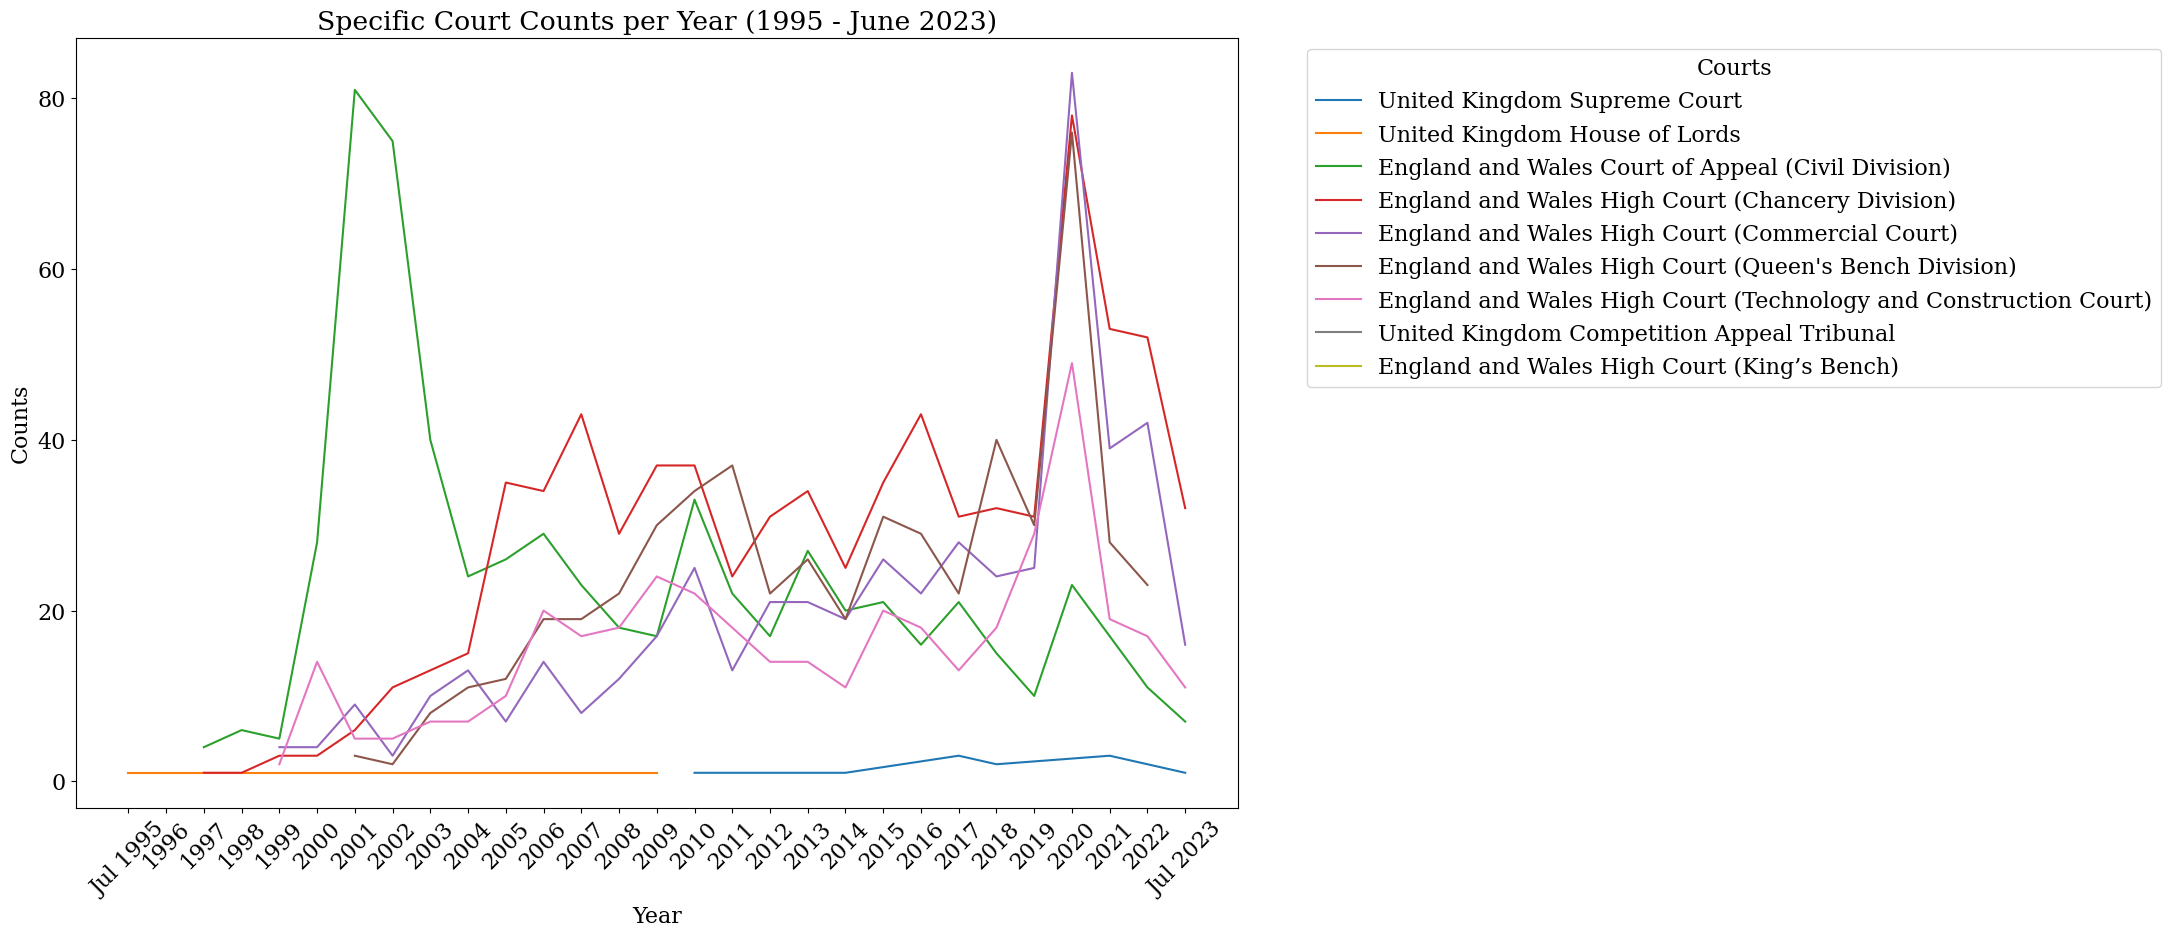

In [108]:
courts_plot1 = [
    "United Kingdom Supreme Court",
    "United Kingdom House of Lords",
    "England and Wales Court of Appeal (Civil Division)",
    "England and Wales High Court (Chancery Division)",
    "England and Wales High Court (Commercial Court)",
    "England and Wales High Court (Queen's Bench Division)",
    "England and Wales High Court (Technology and Construction Court)",
    "United Kingdom Competition Appeal Tribunal",
    "England and Wales High Court (King’s Bench)"
]

df['last_date_hearing_delivery'] = pd.to_datetime(df['last_date_hearing_delivery'])

df['court_lower'] = df['court'].str.lower()

court_counts = df.groupby(['year', 'court']).size().reset_index(name='counts')


min_date = df['last_date_hearing_delivery'].min()
max_date = df['last_date_hearing_delivery'].max()


court_counts = court_counts[(court_counts['year'] >= 1995) & (court_counts['year'] <= 2023)]

mpl.rcParams.update({'font.size': 16})

def plot_courts(courts, title):
    plt.figure(figsize=(15, 10))
    for court in courts:
        subset = court_counts[court_counts['court'] == court]
        plt.plot(subset['year'], subset['counts'], label=court)
    
    plt.title(title)
    plt.xlabel('Year')
    plt.ylabel('Counts')
    plt.legend(title='Courts', bbox_to_anchor=(1.05, 1), loc='upper left')
    

    years = court_counts['year'].unique()
    custom_ticks = [min_date.year, *years[1:-1], max_date.year]  # Keep intermediate years as is
    custom_labels = [min_date.strftime('%b %Y'), *years[1:-1], max_date.strftime('%b %Y')]  # Custom labels for min and max
    
    plt.xticks(ticks=custom_ticks, labels=custom_labels, rotation=45)  # Adjust rotation for better label readability
    
    plt.show()


plot_courts(courts_plot1, 'Specific Court Counts per Year (1995 - June 2023)')



['United Kingdom Competition Appeals Tribunal'
 'England and Wales Court of Appeal (Civil Division)'
 'England and Wales Court of Appeal (Criminal Division)'
 'England and Wales Court of Protection'
 'England and Wales High Court (Administrative Court)'
 'England and Wales High Court (Admiralty Division)'
 'England and Wales High Court (Chancery Division)'
 'England and Wales High Court (Commercial Court)'
 'England and Wales High Court (Family Division)'
 'Intellectual Property Enterprise Court'
 "England and Wales High Court (King's Bench Division)"
 'England and Wales High Court (Mercantile Court)'
 'England and Wales High Court (Patents Court)'
 "England and Wales High Court (Queen's Bench Division)"
 'England and Wales High Court (Technology and Construction Court)'
 'England and Wales Land Registry Adjudicator'
 'England and Wales Leasehold Valuation Tribunal'
 'England and Wales Patents County Court'
 'England and Wales Courts - Miscellaneous'
 'United Kingdom Employment Appeal 

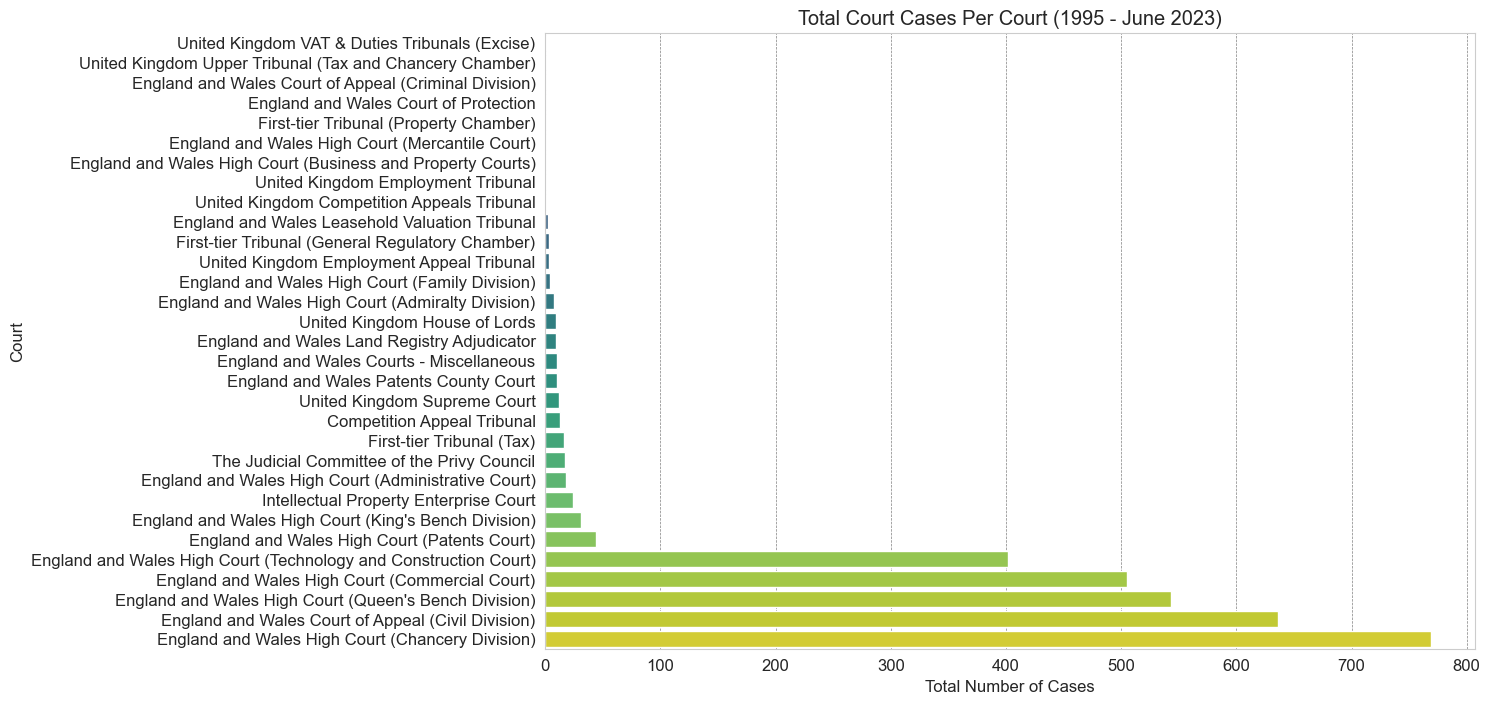

In [118]:

print(df['court'].unique())
df['court_lower'] = df['court'].str.lower()


df_filtered = df[(df['year'] >= 1995) & (df['year'] <= 2023)]

court_counts = df_filtered.groupby('court').size().reset_index(name='counts')


court_counts_sorted = court_counts.sort_values(by='counts', ascending=True)

plt.style.use('default')


plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

with sns.axes_style('whitegrid'):
    plt.figure(figsize=(12, 8))
    sns.barplot(x='counts', y='court', data=court_counts_sorted, palette="viridis")
    plt.title('Total Court Cases Per Court (1995 - June 2023)')
    plt.xlabel('Total Number of Cases')
    plt.ylabel('Court')
    plt.grid(axis='x', color='gray', linestyle='--', linewidth=0.5)
    plt.show()


In [119]:
df['court_lower'] = df['court'].str.lower()
df_filtered = df[(df['year'] >= 1995) & (df['year'] <= 2023)]
court_counts = df_filtered.groupby('court').size().reset_index(name='counts')
court_counts_sorted = court_counts.sort_values(by='counts', ascending=True)
print(court_counts_sorted)

                                                court  counts
30     United Kingdom VAT & Duties Tribunals (Excise)       1
29  United Kingdom Upper Tribunal (Tax and Chancer...       1
2   England and Wales Court of Appeal (Criminal Di...       1
3               England and Wales Court of Protection       1
20             First-tier Tribunal (Property Chamber)       1
12    England and Wales High Court (Mercantile Court)       1
7   England and Wales High Court (Business and Pro...       1
26                 United Kingdom Employment Tribunal       1
24        United Kingdom Competition Appeals Tribunal       1
17     England and Wales Leasehold Valuation Tribunal       2
19   First-tier Tribunal (General Regulatory Chamber)       3
25          United Kingdom Employment Appeal Tribunal       3
10     England and Wales High Court (Family Division)       4
6   England and Wales High Court (Admiralty Division)       8
27                      United Kingdom House of Lords       9
16      

In [22]:
df.to_pickle('SJ_20_2_2024.pkl')

In [89]:
def assign_tier(court_name):
  
    tier_1_courts = [

            "United Kingdom Supreme Court",
            "The Judicial Committee of the Privy Council",
            "United Kingdom House of Lords"

              ]

    
    tier_2_Appellate_courts = [
            "England and Wales Court of Appeal (Civil Division)",
            "COURT OF APPEAL (CIVIL DIVISION)",
            "England and Wales Court of Appeal (Criminal Division)",
        ]

    tier_2_Appellate_Tribunal = [
            "United Kingdom Employment Appeal Tribunal",
            "United Kingdom Competition Appeals Tribunal",
            "Competition Appeal Tribunal"
        ]
     
    tier_3_First_Instance_court = [
            "England and Wales County Court (Family)",
                "England and Wales High Court (Administrative Court)",
                "England and Wales High Court (Chancery Division)",
                "Intellectual Property Enterprise Court",
                "England and Wales High Court (King's Bench Division)",
                "England and Wales High Court (Queen's Bench Division)",
                "England and Wales High Court (Patents Court)",
                "England and Wales High Court (Technology and Construction Court)",
                "England and Wales High Court (Admiralty Division)",
                "England and Wales High Court (Commercial Court)",
                "England and Wales High Court (Family Division)",
                "England and Wales Family Court (High Court Judges)",
                "England and Wales Family Court (other Judges)",
                "Court of Common Pleas",
                "England and Wales Court of Protection",
                "Information Commissioner's Office",
                "United Kingdom Financial Services and Markets Tribunals",
                "First-tier Tribunal (Health Education and Social Care Chamber)",
                "England and Wales Lands Tribunal",
                "First-tier Tribunal (Property Chamber)",
                "England and Wales Patents County Court",
                "England and Wales Courts - Miscellaneous" ,
                'English and Welsh Courts - Miscellaneous',
                "England and Wales High Court (Business and Property Courts)",
                "England and Wales High Court (Mercantile Court)",
                'Mercantile Court'

        ]

    tier_3_First_Instance_Tribunal= [           
                "England and Wales Land Registry Adjudicator",
                "England and Wales Leasehold Valuation Tribunal",
                "First-tier Tribunal (General Regulatory Chamber)", 
                "First-tier Tribunal (Property Chamber)",
                "First-tier Tribunal (Tax)",
                "United Kingdom Employment Tribunal",
                "United Kingdom Upper Tribunal (Tax and Chancery Chamber)",
                "United Kingdom VAT & Duties Tribunals (Excise)" 

            ]

            
   
    if court_name in tier_1_courts:
        return 'Court of Last Resort'
    elif court_name in tier_2_Appellate_courts:
        return 'Appellate Court'
    elif court_name in tier_2_Appellate_Tribunal:
        return 'Appellate Tribunal'
    elif court_name in tier_3_First_Instance_court:
        return 'First Instance Court'
    elif court_name in tier_3_First_Instance_Tribunal:
        return 'First Instance Tribunal'
    else:
        return None  


df['tier'] = df['court'].apply(assign_tier)



init_notebook_mode(connected=True)


grouped = df.groupby(['year', 'tier']).size().reset_index(name='case_count')

traces = []
tiers = sorted(grouped['tier'].unique())
for tier in tiers:
    filtered_data = grouped[grouped['tier'] == tier]
    trace = go.Scatter(
        x=filtered_data['year'],
        y=filtered_data['case_count'],
        mode='lines+markers',
        name=tier  
    )
    traces.append(trace)


layout = go.Layout(
    title='Number of Cases per Year by Court Tier (1995 - June 2023)',
    xaxis=dict(title='Year'),
    yaxis=dict(title='Number of Cases'),
    hovermode='closest'
)


fig = go.Figure(data=traces, layout=layout)
iplot(fig)

In [90]:
 
df = df[df['year'] >= 1995]
 
grouped = df.groupby(['year', 'tier']).size().reset_index(name='case_count')
 
traces = []
tiers = sorted(grouped['tier'].unique())
for tier in tiers:
    filtered_data = grouped[grouped['tier'] == tier]
    trace = go.Scatter(
        x=filtered_data['year'],
        y=filtered_data['case_count'],
        mode='lines+markers',
        name=tier
    )
    traces.append(trace)

 
layout = go.Layout(
    title='Number of Cases per Year by Court Tier',
    xaxis=dict(
        title='Year',
        tickmode='linear',
        ticks='outside',
        tick0=1980,
        dtick=1   
    ),
    yaxis=dict(title='Number of Cases'),
    hovermode='closest'
)
 
fig = go.Figure(data=traces, layout=layout)
iplot(fig)

In [91]:
grouped = df.groupby(['year', 'tier']).size().reset_index(name='case_count')
traces = []
tiers = sorted(grouped['tier'].unique())
for tier in tiers:
    filtered_data = grouped[grouped['tier'] == tier]
    trace = go.Scatter(
        x=filtered_data['year'],
        y=filtered_data['case_count'],
        mode='lines+markers',
        name=tier
    )
    traces.append(trace)
years = sorted(df['year'].unique())
tickvals = years  
ticktext = [str(year) for year in years]  

if 2023 in years:
    index_of_2023 = years.index(2023)
    ticktext[index_of_2023] = "June 2023"  

layout = go.Layout(
    title='Number of Cases per Year by Court Tier (1995 - June 2023)',
    xaxis=dict(
        title='Year',
        tickmode='array',
        tickvals=tickvals,  
        ticktext=ticktext,  
        ticks='outside',
        showgrid=True,  
        gridcolor='rgba(0, 0, 0, 0.1)'  
    ),
    yaxis=dict(
        title='Number of Cases',
        showgrid=True,  
        gridcolor='rgba(0, 0, 0, 0.1)'  
    ),
    hovermode='closest',
    plot_bgcolor='white',  
    paper_bgcolor='white'  
)

fig = go.Figure(data=traces, layout=layout)
iplot(fig)


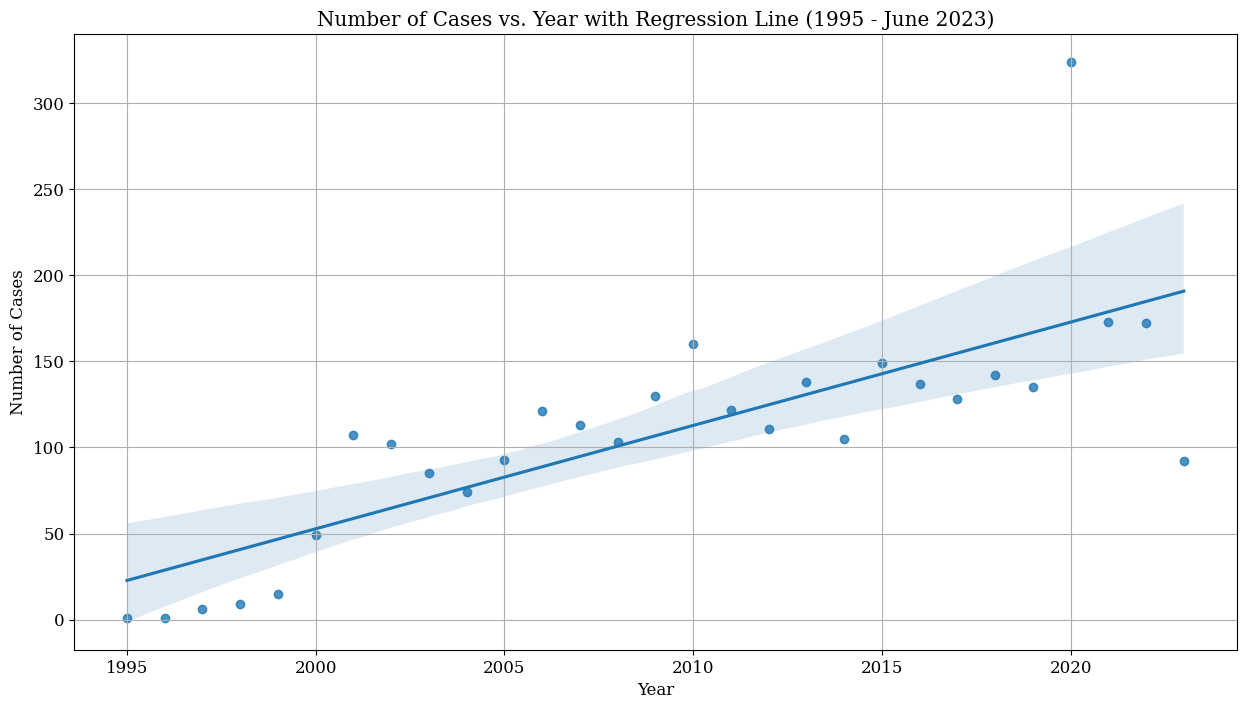

In [92]:
case_count_per_year = df[df['year'] >= 1995].groupby('year').size().reset_index(name='case_count')
plt.figure(figsize=(15, 8))
sns.regplot(x='year', y='case_count', data=case_count_per_year)
plt.title('Number of Cases vs. Year with Regression Line (1995 - June 2023)')
plt.xlabel('Year')
plt.ylabel('Number of Cases')
plt.grid(True)
plt.show()


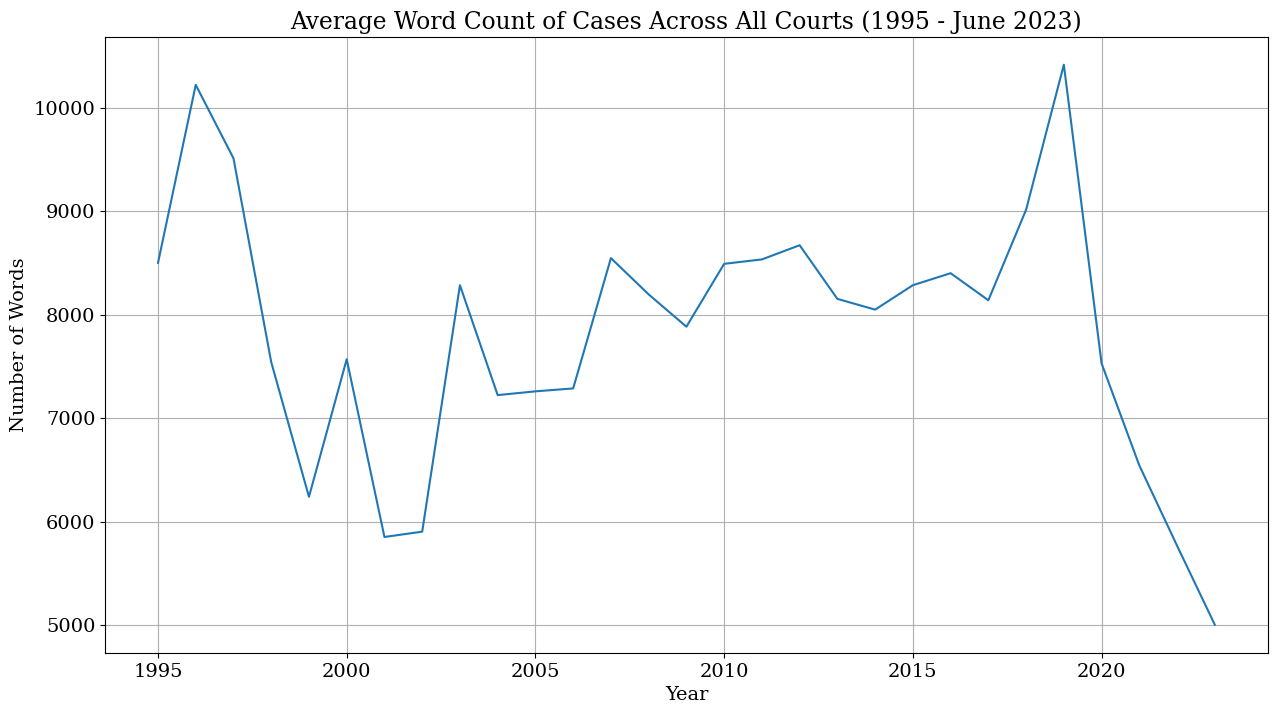

In [93]:
mpl.rcParams.update({'font.size': 14})
df['word_count'] = df['content'].str.split().str.len()
average_word_count_per_year = df[df['year'] >= 1995].groupby('year')['word_count'].mean()
plt.figure(figsize=(15, 8))
plt.plot(average_word_count_per_year.index, average_word_count_per_year.values)
plt.title('Average Word Count of Cases Across All Courts (1995 - June 2023)')
plt.xlabel('Year')
plt.ylabel('Number of Words')
plt.grid(True)
plt.show()


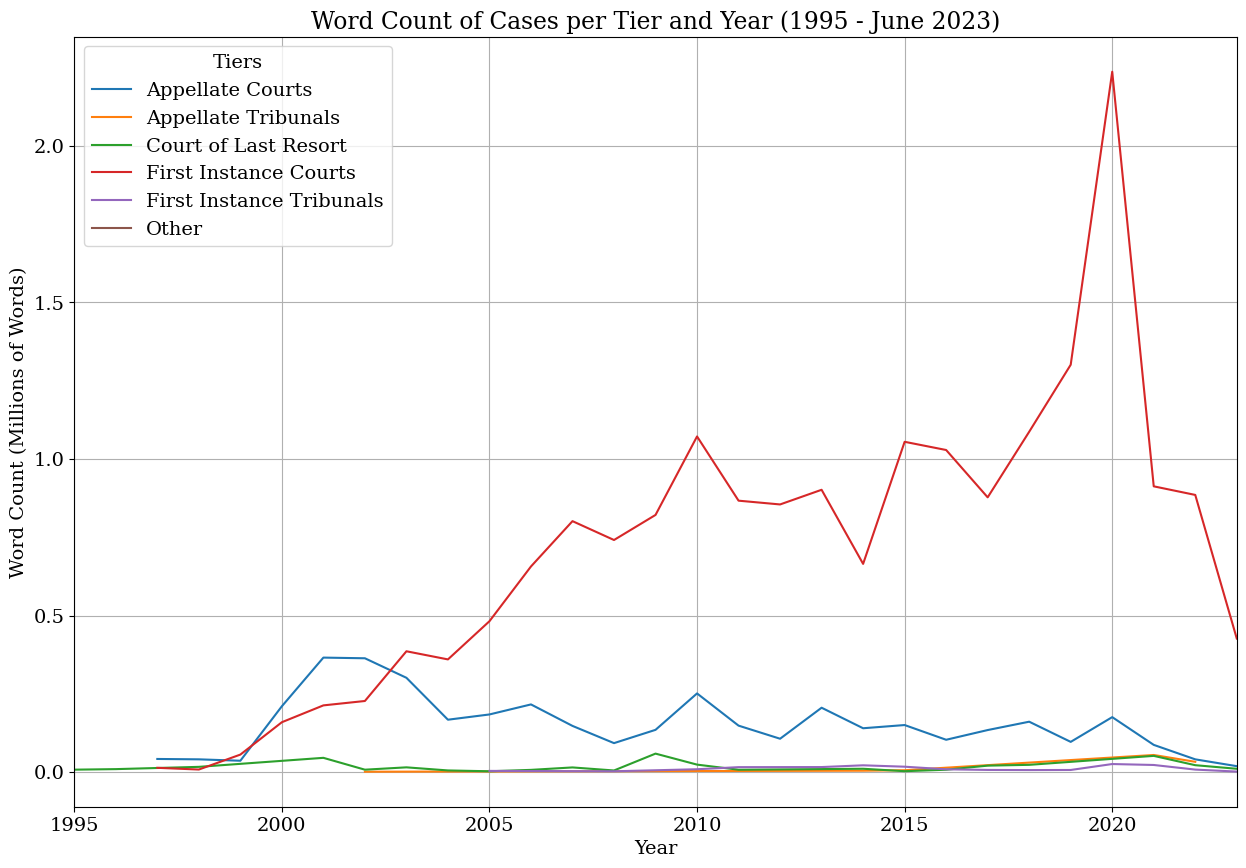

In [94]:
tier_1_courts = [

            "United Kingdom Supreme Court",
            "The Judicial Committee of the Privy Council",
            "United Kingdom House of Lords"

              ]


tier_2_Appellate_courts = [
            "England and Wales Court of Appeal (Civil Division)",
            "COURT OF APPEAL (CIVIL DIVISION)",
            "England and Wales Court of Appeal (Criminal Division)",
        ]

tier_2_Appellate_Tribunal = [
            "United Kingdom Employment Appeal Tribunal",
            "United Kingdom Competition Appeal Tribunal",
            "Competition Appeal Tribunal"
        ]

tier_3_First_Instance_court = [
            "England and Wales County Court (Family)",
                "England and Wales High Court (Administrative Court)",
                "England and Wales High Court (Chancery Division)",
                "Intellectual Property Enterprise Court",
                "England and Wales High Court (King's Bench Division)",
                "England and Wales High Court (Queen's Bench Division)",
                "England and Wales High Court (Patents Court)",
                "England and Wales High Court (Technology and Construction Court)",
                "England and Wales High Court (Admiralty Division)",
                "England and Wales High Court (Commercial Court)",
                "England and Wales High Court (Family Division)",
                "England and Wales Family Court (High Court Judges)",
                "England and Wales Family Court (other Judges)",
                "Court of Common Pleas",
                "England and Wales Court of Protection",
                "Information Commissioner's Office",
                "United Kingdom Financial Services and Markets Tribunals",
                "First-tier Tribunal (Health Education and Social Care Chamber)",
                "England and Wales Lands Tribunal",
                "First-tier Tribunal (Property Chamber)",
                "England and Wales Patents County Court",
                "England and Wales Courts - Miscellaneous" ,
                'English and Welsh Courts - Miscellaneous',
                "England and Wales High Court (Business and Property Courts)",
                "England and Wales High Court (Mercantile Court)",
                'Mercantile Court'

        ]

tier_3_First_Instance_Tribunal= [           
                "England and Wales Land Registry Adjudicator",
                "England and Wales Leasehold Valuation Tribunal",
                "First-tier Tribunal (General Regulatory Chamber)", 
                "First-tier Tribunal (Property Chamber)",
                "First-tier Tribunal (Tax)",
                "United Kingdom Employment Tribunal",
                "United Kingdom Upper Tribunal (Tax and Chancery Chamber)",
                "United Kingdom VAT & Duties Tribunals (Excise)" 

            ]

def assign_tier(court_name):
    if court_name in tier_1_courts:
        return 'Court of Last Resort'
    elif court_name in tier_2_Appellate_courts:
        return 'Appellate Courts'
    elif court_name in tier_2_Appellate_Tribunal:
        return 'Appellate Tribunals'
    elif court_name in tier_3_First_Instance_court:
        return 'First Instance Courts'
    elif court_name in tier_3_First_Instance_Tribunal:
        return 'First Instance Tribunals'
    else:
        return 'Other'  

df['tier'] = df['court'].apply(assign_tier)

df['word_count'] = df['content'].str.split().str.len()


word_count_per_tier_year = df.groupby(['tier', 'year'])['word_count'].sum().reset_index()


plt.figure(figsize=(15, 10))


for tier in word_count_per_tier_year['tier'].unique():
    subset = word_count_per_tier_year[word_count_per_tier_year['tier'] == tier]
    plt.plot(subset['year'], subset['word_count'], label=tier)
plt.xlim(1995, 2023)

plt.title('Word Count of Cases per Tier and Year (1995 - June 2023)')
plt.xlabel('Year')
plt.ylabel('Word Count (Millions of Words)')
plt.legend(title='Tiers')

plt.gca().get_yaxis().get_offset_text().set_visible(False)
plt.grid(True)
plt.show()


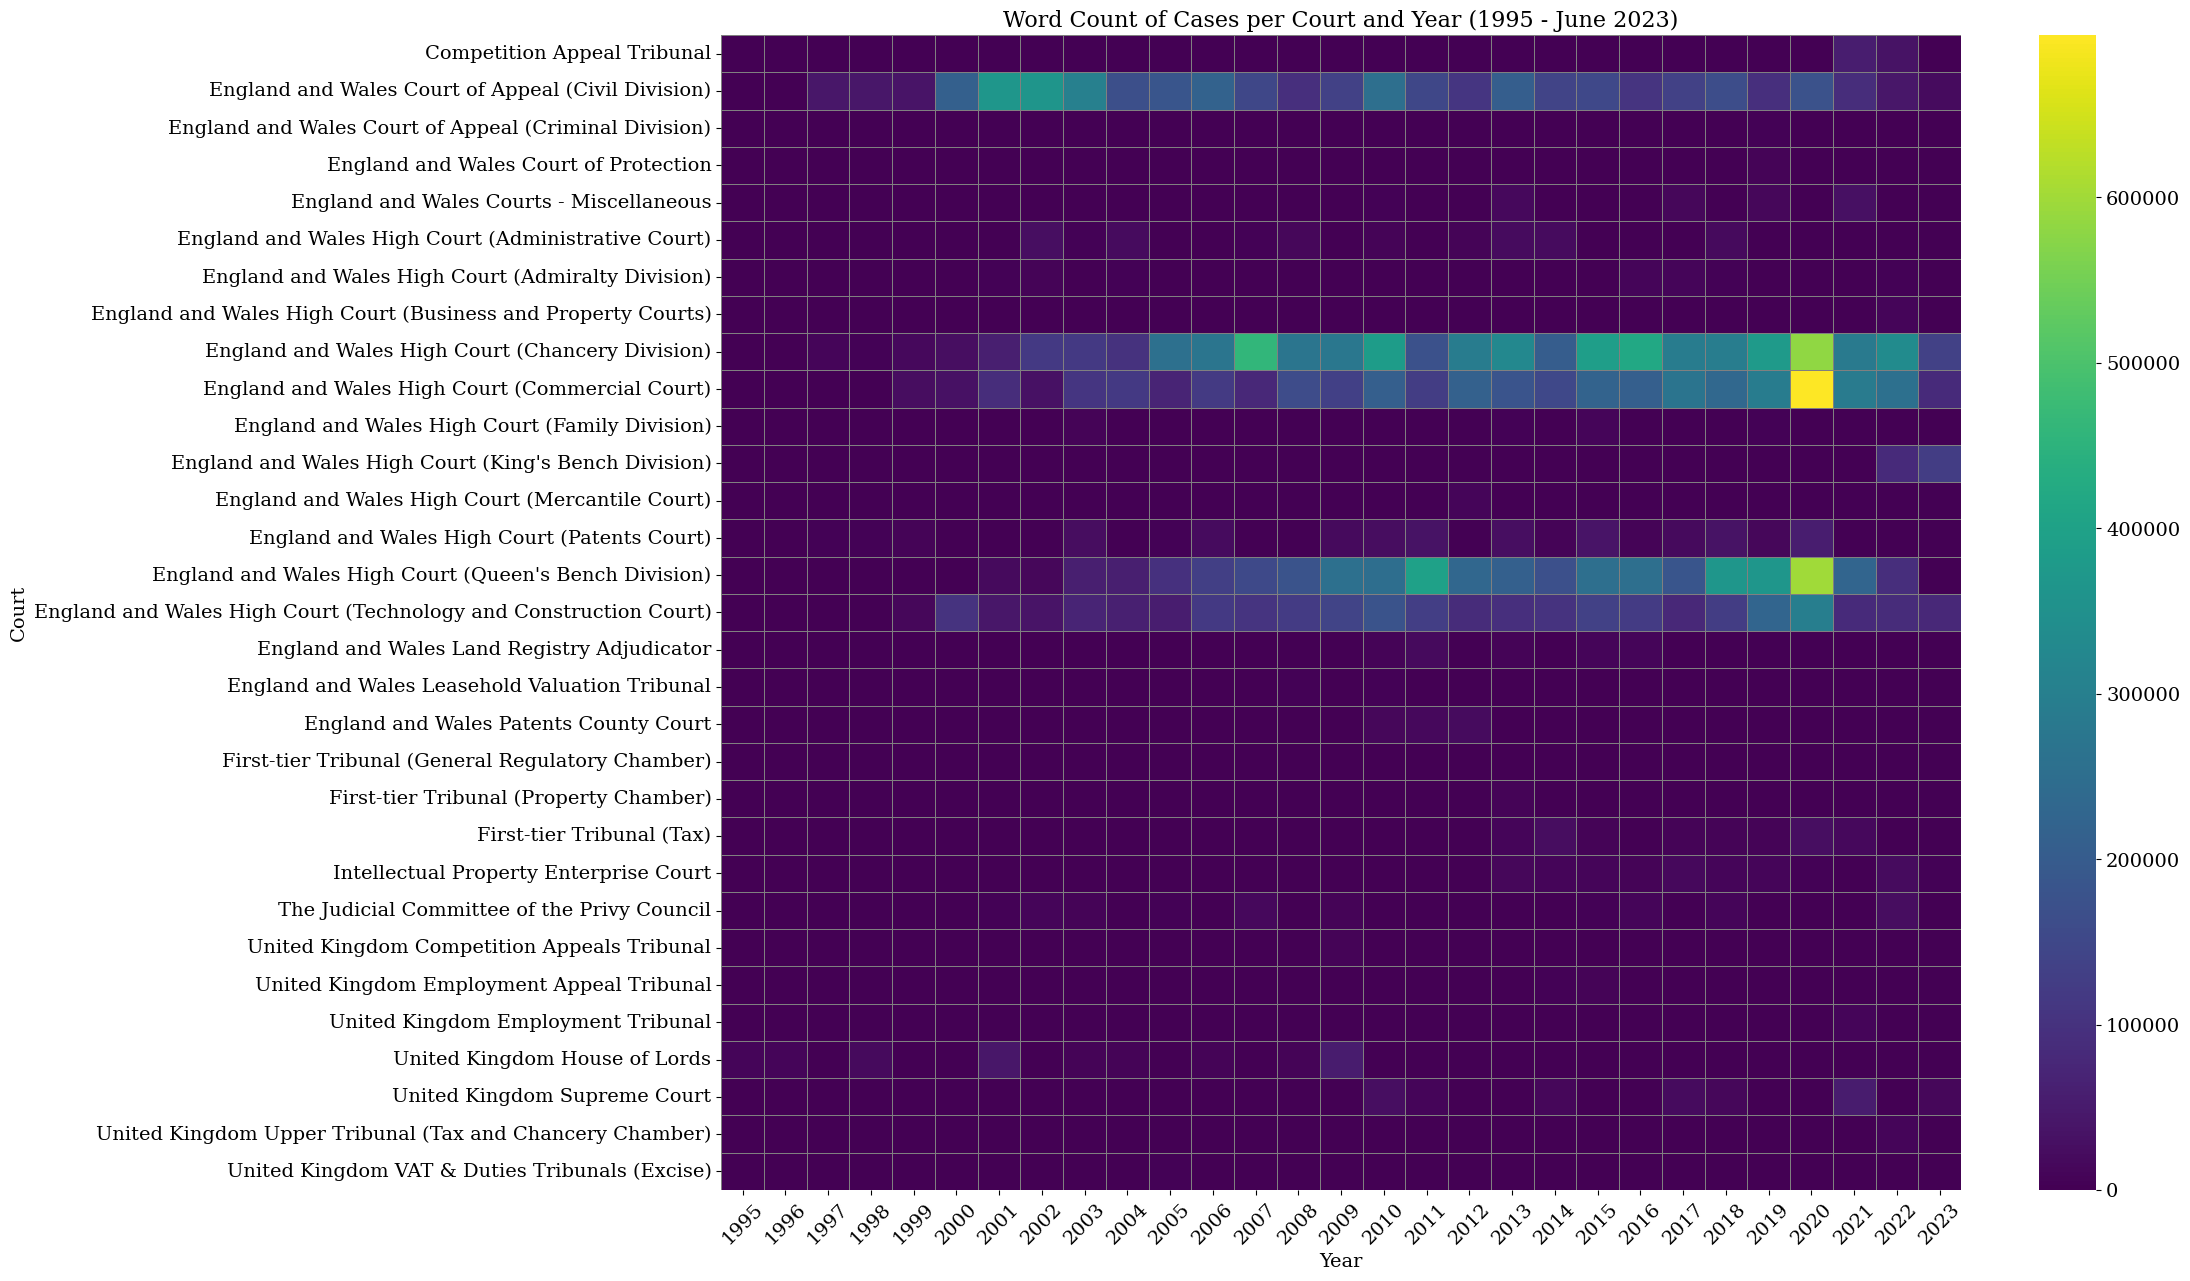

In [95]:
df['court_lower'] = df['court'].str.lower()

df['word_count'] = df['content'].str.split().str.len()

word_count_per_court_year = df.groupby(['court', 'year'])['word_count'].sum().reset_index()

pivot_table = word_count_per_court_year.pivot(index='court', columns='year', values='word_count').fillna(0)

plt.figure(figsize=(20, 15))
sns.heatmap(pivot_table, annot=False, cmap='viridis', linewidths=.5, linecolor='gray')
plt.title('Word Count of Cases per Court and Year (1995 - June 2023)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Court', fontsize=14)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

In [172]:
from sklearn.cluster import KMeans
k = 10  
kmeans = KMeans(n_clusters=k, random_state=34 )
word_count_per_court_year['cluster'] = kmeans.fit_predict(word_count_per_court_year[['word_count']])

cluster_sizes = word_count_per_court_year['cluster'].value_counts().sort_index()

cluster_ranges = word_count_per_court_year.groupby('cluster')['word_count'].agg([min, max])

cluster_info = pd.concat([cluster_ranges, cluster_sizes], axis=1)
cluster_info.columns = ['Min Word Count', 'Max Word Count', 'Size']

sorted_clusters = cluster_info.sort_values(by='Size', ascending=False)

print(sorted_clusters)

pastel_colors = ['#FDB9C8', '#B6E2D3', '#F6C3B8', '#CBDDF9', '#FDE4CF',
                 '#B8AED2', '#D1F2EB', '#FBD1A2', '#A1C9F4', '#D8BFD8']

fig = px.scatter(word_count_per_court_year, x='word_count', y='year', color='cluster',
                 title="Word Count Clusters",
                 labels={"word_count": "Word Count", "year": "Year", "cluster": "Cluster"},
                 color_discrete_sequence=pastel_colors[:k]) 

fig.update_layout(showlegend=True, template="plotly_dark")
fig.for_each_trace(lambda t: t.update(name = t.name.replace('cluster=', 'Cluster=')))

fig.show()


   Min Word Count  Max Word Count  Size
1             303           27496   121
5           69089          107236    23
7           30120           62597    22
6          108999          140973    20
0          148199          185071    16
8          203849          234459    13
3          250286          277322    11
2          364077          460656    10
9          285501          334918    10
4          582606          698191     3


In [98]:
df['court_lower'] = df['court'].str.lower()
df['word_count'] = df['content'].str.split().str.len()
word_count_per_court_year = df.groupby(['court_lower', 'year'])['word_count'].sum().reset_index()
mean_word_count = word_count_per_court_year['word_count'].mean()
median_word_count = word_count_per_court_year['word_count'].median()
std_dev_word_count = word_count_per_court_year['word_count'].std()
quartiles_word_count = word_count_per_court_year['word_count'].quantile([0.25, 0.5, 0.75])
(mean_word_count, median_word_count, std_dev_word_count, quartiles_word_count)
print('mean: ',mean_word_count)
print('median: ',median_word_count)
print('sd: ',std_dev_word_count)
print('quartiles', quartiles_word_count)

mean:  96120.22088353413
median:  33588.0
sd:  121843.51343061449
quartiles 0.25      8472.0
0.50     33588.0
0.75    148199.0
Name: word_count, dtype: float64


In [138]:
df['court_lower'] = df['court'].str.lower()
df['word_count'] = df['content'].str.split().str.len()
word_count_per_court_year = df.groupby(['court_lower', 'year'])['word_count'].sum().reset_index()

k = 2 

kmeans = KMeans(n_clusters=k, random_state=34)
word_count_per_court_year['cluster'] = kmeans.fit_predict(word_count_per_court_year[['word_count']])

for i in range(k):
    cluster = word_count_per_court_year[word_count_per_court_year['cluster'] == i]
    min_count = cluster['word_count'].min()
    max_count = cluster['word_count'].max()
    percent = len(cluster) / len(word_count_per_court_year) * 100
    print(f"Cluster {i+1}: {min_count} - {max_count} words, {percent:.2f}% of cases")


Cluster 1: 167969 - 698191 words, 22.49% of cases
Cluster 2: 303 - 161604 words, 77.51% of cases


In [140]:
df['court_lower'] = df['court'].str.lower()
df['word_count'] = df['content'].str.split().str.len()
word_count_per_court_year = df.groupby(['court_lower', 'year'])['word_count'].sum().reset_index()

k = 10  


kmeans = KMeans(n_clusters=k, random_state=34)
word_count_per_court_year['cluster'] = kmeans.fit_predict(word_count_per_court_year[['word_count']])


for i in range(k):
    cluster = word_count_per_court_year[word_count_per_court_year['cluster'] == i]
    min_count = cluster['word_count'].min()
    max_count = cluster['word_count'].max()
    percent = len(cluster) / len(word_count_per_court_year) * 100
    print(f"Cluster {i+1}: {min_count} - {max_count} words, {percent:.2f}% of cases")


Cluster 1: 148199 - 185071 words, 6.43% of cases
Cluster 2: 303 - 27496 words, 48.59% of cases
Cluster 3: 364077 - 460656 words, 4.02% of cases
Cluster 4: 250286 - 277322 words, 4.42% of cases
Cluster 5: 582606 - 698191 words, 1.20% of cases
Cluster 6: 69089 - 107236 words, 9.24% of cases
Cluster 7: 108999 - 140973 words, 8.03% of cases
Cluster 8: 30120 - 62597 words, 8.84% of cases
Cluster 9: 203849 - 234459 words, 5.22% of cases
Cluster 10: 285501 - 334918 words, 4.02% of cases
